In [38]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import*

from collections import*

from sklearn.metrics import*


In [39]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                



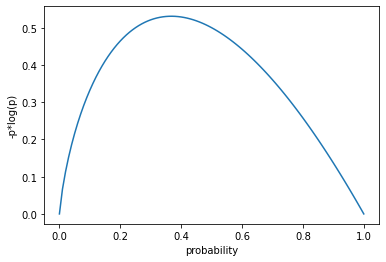

In [40]:
x = [i/100.0 for i in range(101) ]
entropy_x = [0] + [-p*math.log(p,2) for p in x if p > 0]
# import matplotlib.pyplot as plt
plt.plot(x, entropy_x)
plt.xlabel('probability')
plt.ylabel('-p*log(p)')
plt.show()

In [41]:
# Entropy
def entropy(class_probabilities):
    """Given a list of class probabilities, compute the entropy"""
    ent = sum(-p * math.log(p, 2)
               for p in class_probabilities 
               if p > 0)
#     ent_0 = []
#     for p in class_probabilities :
#         if p > 0:
#             ent_0.append(-p * math.log(p,2))
#     ent = sum(ent_0)
            
    return ent

def class_probabilities(labels):
    total_count = len(labels)
    class_prob = [count / total_count for count in Counter(labels).values()]
    return class_prob

def data_entropy(labels):
    data_ent = entropy(class_probabilities(labels))
    return data_ent



In [42]:
# The Entropy of a Partition

def partition_entropy(subsets):
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    part_ent = sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

    return part_ent


In [43]:
x = np.arange(0,50)
# x = pd.DataFrame({'x':x})

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

x = x.tolist()
y = y.tolist()

In [44]:
# Creating a Decision Tree

# Test
# Create class
class Candidate(NamedTuple):
    level: int
    did_well: float # allow unlabeled data
# Data
# inputs = [Candidate('Senior', 'Java',   False, False, False),
#           Candidate('Senior', 'Java',   False, True,  False),
#           Candidate('Mid',    'Python', False, False, True),
#           Candidate('Junior', 'Python', False, False, True),
#           Candidate('Junior', 'R',      True,  False, True),
#           Candidate('Junior', 'R',      True,  True,  False),
#           Candidate('Mid',    'R',      True,  True,  True),
#           Candidate('Senior', 'Python', False, False, False),
#           Candidate('Senior', 'R',      True,  False, True),
#           Candidate('Junior', 'Python', True,  False, True),
#           Candidate('Senior', 'Python', True,  True,  True),
#           Candidate('Mid',    'Python', False, True,  True),
#           Candidate('Mid',    'Java',   True,  False, True),
#           Candidate('Junior', 'Python', False, True,  False)
#          ]


# inputs = [Candidate('Senior', False),
#           Candidate('Senior', False),
#           Candidate('Mid',    True),
#           Candidate('Junior', True),
#           Candidate('Junior', True),
#           Candidate('Junior', False),
#           Candidate('Mid',  True),
#           Candidate('Senior', False),
#           Candidate('Senior', True),
#           Candidate('Junior', True),
#           Candidate('Senior', True),
#           Candidate('Mid',    True),
#           Candidate('Mid',    True),
#           Candidate('Junior', False)
#          ]

# inputs = [Candidate(x[0],y[0]),
#          Candidate(x[1],y[1]),
#          Candidate(x[2],y[2]),
#          Candidate(x[40],y[40])]

inputs=[]
for i in range(len(x)):
    inputs.append(Candidate(x[i],y[i]))

# Generic type of inputs
T = TypeVar('T')

# def partition_by(inputs, attribute):
#     """Partition the inputs into lists based on the specified attribute."""
#     partitions: Dict[Any, List[T]] = defaultdict(list)
#     for input in inputs:
#         key = getattr(input, attribute)  # value of the specified attribute
#         partitions[key].append(input)    # add input to the correct partition
#     return partitions

# # Compute Entropy
# def partition_entropy_by(inputs, attribute, label_attribute):
#     """Compute the entropy corresponding to the given partition"""
#     # partitions consist of our inputs 
#     partitions = partition_by(inputs, attribute)

#     # but partition_entropy needs just the class labels
#     labels = [[getattr(input, label_attribute) for input in partition]
#               for partition in partitions.values()]

#     return partition_entropy(labels)

# for key in ['level']:
#     print(key, partition_entropy_by(inputs, key, 'did_well'))

# partition_entropy_by(inputs, 'level', 'did_well')

# senior_inputs = [input for input in inputs if input.level == 'Senior']

# senior_inputs

# type(senior_inputs)
inputs[0][1]
# type(inputs)
inputs

[Candidate(level=0, did_well=[12.434951299901146]),
 Candidate(level=1, did_well=[10.245397072307355]),
 Candidate(level=2, did_well=[12.688355199129873]),
 Candidate(level=3, did_well=[14.32666401361703]),
 Candidate(level=4, did_well=[14.789427193729907]),
 Candidate(level=5, did_well=[12.881218761244703]),
 Candidate(level=6, did_well=[14.216279457709621]),
 Candidate(level=7, did_well=[11.896640106546336]),
 Candidate(level=8, did_well=[14.72881474976908]),
 Candidate(level=9, did_well=[12.024129821548087]),
 Candidate(level=10, did_well=[21.8763994779284]),
 Candidate(level=11, did_well=[24.00770339164069]),
 Candidate(level=12, did_well=[22.64117437649812]),
 Candidate(level=13, did_well=[22.11090587561574]),
 Candidate(level=14, did_well=[23.805161195947903]),
 Candidate(level=15, did_well=[22.94165963958391]),
 Candidate(level=16, did_well=[23.030106147482076]),
 Candidate(level=17, did_well=[23.739345404121735]),
 Candidate(level=18, did_well=[21.891857501480892]),
 Candidate(

In [45]:
# Creating a Decision Tree

# def partition_by(inputs, attribute):
#     """Partition the inputs into lists based on the specified attribute."""
#     partitions: Dict[Any, List[T]] = defaultdict(list)
#     for input in inputs:
#         key = getattr(input, attribute)  # value of the specified attribute
#         partitions[key].append(input)    # add input to the correct partition
#     return partitions

# # Compute Entropy
# def partition_entropy_by(inputs, attribute, label_attribute):
#     """Compute the entropy corresponding to the given partition"""
#     # partitions consist of our inputs 
#     partitions = partition_by(inputs, attribute)

#     # but partition_entropy needs just the class labels
#     labels = [[getattr(input, label_attribute) for input in partition]
#               for partition in partitions.values()]

#     return partition_entropy(labels)

# for key in ['level']:
#     print(key, partition_entropy_by(inputs, key, 'did_well'))

# partition_entropy_by(inputs, 'level', 'did_well')

# senior_inputs = [input for input in inputs if input.level == 'Senior']

# senior_inputs

# type(senior_inputs)
# inputs
# type(inputs)

# partition_by
partitions: Dict[Any, List[T]] = defaultdict(list)
for input in inputs:
    key = getattr(input, 'level')  # value of the specified attribute
    partitions[key].append(input)    # add input to the correct partition

# partition_entropy_by
labels = [[getattr(input, 'did_well') for input in partition]
          for partition in partitions.values()]

# abcde = []
# for j in range(len(labels)):
#     abcde.append(Counter(labels[j][0]))
# abcde
# labels
# Entropy
# def entropy(class_probabilities):
#     """Given a list of class probabilities, compute the entropy"""
#     ent = sum(-p * math.log(p, 2)
#                for p in class_probabilities 
#                if p > 0)
# #     ent_0 = []
# #     for p in class_probabilities :
# #         if p > 0:
# #             ent_0.append(-p * math.log(p,2))
# #     ent = sum(ent_0)
            
#     return ent


# partition_entropy

total_count = len(labels)
class_prob = [count / total_count for count in Counter(labels[0][0]).values()]

# # for count in labels:
# #     print(count[0]/total_count)

data_ent = sum(-p * math.log(p, 2)
               for p in class_prob
               if p > 0)


subsets = labels
total_count = sum(len(subset) for subset in subsets)
# data_ent = entropy(class_probabilities(subsets))
part_ent = sum(data_ent * len(subset) / total_count for subset in subsets)
print(part_ent)
# # labels[0][0]
# part_ent
# class_prob
# abcde


0.11287712379549462


In [46]:
# senior_inputs = [input for input in inputs if input.level == x[0]]
# senior_inputs
# y

In [47]:
# Putting It All Together

from statistics import mode

class Leaf(NamedTuple): 
     value: Any
            
class Split(NamedTuple):
    attribute:Any
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

# for input in inputs:
#     print(Counter(getattr(input, 'did_well')))
label_counts = [getattr(input, 'did_well') for input in inputs]
# acl = Counter(label_counts)
# # mode(acl)

print(label_counts)

most_common = max(label_counts, key = label_counts.count)
# print(most_common)

# most_common_label  label_counts.most_common(1)[0][0]
# most_com
if len(label_counts) == 1:
    cnt_return = Leaf(most_common)
if not 'level':
    cnt_return = Leaf(most_common)

best_attribute = min(inputs)
best_attribute

inputs[0][1]
# Create lists
att_list = []
for i in range(len(inputs)):
    att_list.append(inputs[i][1])
    
best_attribute = min(att_list)

# c = Counter()
# np.array(label_counts)
# c.update(np.array(label_counts))
inputs

[[12.434951299901146], [10.245397072307355], [12.688355199129873], [14.32666401361703], [14.789427193729907], [12.881218761244703], [14.216279457709621], [11.896640106546336], [14.72881474976908], [12.024129821548087], [21.8763994779284], [24.00770339164069], [22.64117437649812], [22.11090587561574], [23.805161195947903], [22.94165963958391], [23.030106147482076], [23.739345404121735], [21.891857501480892], [21.685029332462125], [2.0950235213288444], [3.9444555811917463], [0.43775793923449935], [0.46650927386721275], [4.990785455688702], [3.916765957971104], [1.27428270107386], [4.738349143585803], [1.8736563868245808], [2.0809705063563144], [31.61439233665336], [31.398494005158923], [30.392759346474985], [31.946742116586982], [31.337734755568647], [30.911353951986133], [31.259319845843827], [31.25454726951198], [30.332903553896834], [30.200376815065145], [14.258567017926126], [13.140050395091965], [13.015479073035307], [15.539182578523107], [14.473703896650514], [13.71822509686995], [

[Candidate(level=0, did_well=[12.434951299901146]),
 Candidate(level=1, did_well=[10.245397072307355]),
 Candidate(level=2, did_well=[12.688355199129873]),
 Candidate(level=3, did_well=[14.32666401361703]),
 Candidate(level=4, did_well=[14.789427193729907]),
 Candidate(level=5, did_well=[12.881218761244703]),
 Candidate(level=6, did_well=[14.216279457709621]),
 Candidate(level=7, did_well=[11.896640106546336]),
 Candidate(level=8, did_well=[14.72881474976908]),
 Candidate(level=9, did_well=[12.024129821548087]),
 Candidate(level=10, did_well=[21.8763994779284]),
 Candidate(level=11, did_well=[24.00770339164069]),
 Candidate(level=12, did_well=[22.64117437649812]),
 Candidate(level=13, did_well=[22.11090587561574]),
 Candidate(level=14, did_well=[23.805161195947903]),
 Candidate(level=15, did_well=[22.94165963958391]),
 Candidate(level=16, did_well=[23.030106147482076]),
 Candidate(level=17, did_well=[23.739345404121735]),
 Candidate(level=18, did_well=[21.891857501480892]),
 Candidate(

In [48]:
subtrees_1 = []
trees_lst = []
trees_sub = []
for attribute_value,subset in partitions.items():
    label_counts = [getattr(input, 'did_well') for input in subset]
# acl = Counter(label_counts)
# # mode(acl)

#     print(label_counts)

    most_common = max(label_counts, key = label_counts.count)
#     print(most_common)

# # most_common_label  label_counts.most_common(1)[0][0]
# # most_com
    if len(label_counts) == 1:
        cnt_return = Leaf(most_common)
    if not 'level':
        cnt_return = Leaf(most_common)

    best_attribute = min(label_counts)
#     print(best_attribute)
    
    subtrees_1.append(best_attribute)

# inputs[0][1]
# # Create lists
# att_list = []
# for i in range(len(inputs)):
#     att_list.append(inputs[i][1])
    
# best_attribute = min(att_list)
    subtrees_1 = label_counts

    trees_lst.append(Split(best_attribute,subtrees_1,default_value=most_common))
#     trees_sub.append(trees_lst[0].subtrees)
# print(best_attribute)
aqw = trees_lst[1].subtrees
aqw
for i in range(len(trees_lst)):
    aqw = trees_lst[i].subtrees
    trees_sub.append(aqw[0][0])
# trees_sub
# partitions.items()
adf = trees_lst[0].subtrees
adf

[[12.434951299901146], [10.245397072307355]]

In [49]:
trees_lst[0].subtrees

[[12.434951299901146], [10.245397072307355]]

In [50]:
trees_lst[0]

Split(attribute=[12.434951299901146], subtrees=[[12.434951299901146], [10.245397072307355]], default_value=[12.434951299901146])

In [51]:
trees_lst[3][0]

[14.32666401361703]

In [52]:
# adf = trees_lst[subtree_key].subtrees
# adf

In [53]:
# if isinstance(trees, Leaf):
#     inst = trees.value
 
ad = Candidate(42,42)
subtree_key = getattr(ad,'level')
subtree_key
# type(trees.attribute)
# inputs
# trees.subtrees[0]

# ad = Candidate(0,10)
# ad

subtree1 = []

for _ in range(len(trees_lst)):
    if subtree_key not in trees_sub:
        adf = trees_lst[subtree_key].default_value
        subtree1 = adf[0]
    else:
        subtree1 = trees_lst[subtree_key].subtrees
        

# subtree
# trees.subtrees
subtree_key
# subtree
# trees_lst[subtree_key]

42

In [54]:
# subtree_key = getattr(ad, 'level')

# if subtree_key not in tree.subtrees:   # If no subtree for key,
#     return tree.default_value          # return the default value.

# subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
# return classify(subtree, input)        # and use it to classify the input.

In [55]:
# adf = trees_lst[subtree_key].default_value
# adf = trees_lst[subtree_key].subtrees
# adf = trees_lst.subtrees
trees_lst[subtree_key].default_value

[13.015479073035307]

In [56]:
# subtree_key = getattr(ad,'level')
# subtree_key

# if subtree_key not in subtree1:
#     adf = trees_lst[subtree_key].default_value
#     subtree2.append(adf[0])
# else:
#     subtree2.append(trees_lst[subtree_key].subtrees)

# subtree2

In [57]:
trees_lst[42]

Split(attribute=[13.015479073035307], subtrees=[[13.015479073035307], [15.539182578523107]], default_value=[13.015479073035307])

In [58]:
# inputs[subtree_key][1]
# leaf = [x[subtree_key],y[subtree_key],subtree]
# leaf

In [59]:
subtree_lst = []
actual_val = []
estimate_val = []
for i in range(10):
    
    ad = Candidate(x[i],y[i])
    subtree_key = getattr(ad,'level')
    subtree_key

    if subtree_key not in trees_sub:
        adf = trees_lst[subtree_key].subtrees
        subtree = adf[1]
    else:
        subtree = trees_lst.subtrees

    actual_val.append(y[i])
    estimate_val.append(subtree)
    
mae = mean_absolute_error(actual_val, estimate_val)
mae

rms = mean_squared_error(actual_val, estimate_val, squared=False)
print(mae,rms)

2.76856220569538 3.699574597365036


In [60]:
# # subtrees = {attribute_value : build_tree_id3(inputs,
# #                                                  'level', 
# #                                                  'did_well')}

# for attribute_value, subset in partitions.items():
#     print(subset)
#     print(attribute_value)
#     build_tree_id3(subset,['level'],'did_well')
#     subtrees = {'attribute_value':build_tree_id3(subset,['level'],'did_well')}


In [61]:
# # Putting It All Together

# class Leaf(NamedTuple): 
#      value: Any
            
# class Split(NamedTuple):
#     attribute:Any
#     subtrees: dict
#     default_value: Any = None

# DecisionTree = Union[Leaf, Split]

# # Representation
# # hiring_tree = Split('level', {   # first, consider "level"
# #     'Junior': Split('phd', {     # if level is "Junior", next look at "phd"
# #         False: Leaf(True),       #   if "phd" is False, predict True
# #         True: Leaf(False)        #   if "phd" is True, predict False
# #     }),
# #     'Mid': Leaf(True),           # if level is "Mid", just predict True
# #     'Senior': Split('tweets', {  # if level is "Senior", look at "tweets"
# #         False: Leaf(False),      #   if "tweets" is False, predict False
# #         True: Leaf(True)         #   if "tweets" is True, predict True
# #     })
# # })

# hiring_tree = Split('level',{'Junior' : Split('phd', {False:Leaf(True),True: Leaf(False)}),
#                              'Mid': Leaf(True), 'Senior': Split('tweets', {False:Leaf(False),True:Leaf(True)})})

# def classify(tree, input):
#     """classify the input using the given decision tree"""

#     # If this is a leaf node, return its value
#     if isinstance(tree, Leaf):
#         return tree.value 

#     # Otherwise this tree consists of an attribute to split on
#     # and a dictionary whose keys are values of that attribute
#     # and whose values are subtrees to consider next 
    
#     subtree_key = getattr(input, tree.attribute)

#     if subtree_key not in tree.subtrees:   # If no subtree for key,
#         return tree.default_value          # return the default value.

#     subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
#     return classify(subtree, input)        # and use it to classify the input.

# def build_tree_id3(inputs, split_attributes, target_attribute):
#     # Count target labels
#     label_counts = Counter(getattr(input, target_attribute) for input in inputs)
#     most_common_label = label_counts.most_common(1)[0][0]

#     # If there's a unique label, predict it
#     if len(label_counts) == 1:
#         return Leaf(most_common_label)

#     # If no split attributes left, return the majority label
#     if not split_attributes:
#         return Leaf(most_common_label)
    
#     # Otherwise split by the best attribute
#     def split_entropy(attribute):
# #     """Helper function for finding the best attribute"""
#         return partition_entropy_by(inputs, attribute, target_attribute)

#     best_attribute = min(split_attributes, key=split_entropy)
#     partitions = partition_by(inputs, best_attribute)
#     new_attributes = [a for a in split_attributes if a != best_attribute]
#     # Recursively build the subtrees
#     subtrees = {attribute_value : build_tree_id3(subset, new_attributes, target_attribute)
#                for attribute_value, subset in partitions.items()}
#     return Split(best_attribute, subtrees, default_value=most_common_label)

# tree = build_tree_id3(inputs, ['level'], 'did_well')

# # Tests
# test_a = classify(tree, Candidate("Junior"))
# test_b = classify(tree, Candidate("Junior"))
# test_c = classify(tree, Candidate("Intern"))
# test_c

In [62]:
# Random Forests

def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

def build_forest_id3(inputs, split_candidates=None, num_split_candidates=None):

    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    
    # count Trues and Falses in the inputs
    num_trues = len([label for item, label in inputs if label])
    num_falses = len(inputs) - num_trues
    
    if num_trues == 0:
        return False
    
    if num_falses == 0:
        return True
    
    if not split_candidates:
        return num_trues >= num_falses
    
    # if there's already few enough split candidates, look at all of them
    if num_split_candidates is None or len(split_candidates) <= num_split_candidates:
        sampled_split_candidates = split_candidates    
    # otherwise pick a random sample
    else:
        sampled_split_candidates = random.sample(split_candidates, num_split_candidates)

    # otherwise, split on the best attribute
    best_attribute = min(sampled_split_candidates, key=split_entropy)
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }
    
    subtrees[None] = num_trues > num_falses # default case
    
    return (best_attribute, subtrees)

def build_forest(inputs, n=3):
    return [build_tree_id3(inputs, num_split_candidates=3) for i in range(n)]



In [63]:
# # if there are already few enough split candidates, look at all of them
# if len(split_candidates) <= self.num_split_candidates:
#     sampled_split_candidates = split_candidates
# # otherwise pick a random sample
# # else:
# #     sampled_split_candidates = random.sample(split_candidates, self.num_split_candidates)                                    self.num_split_candidates)

# # now choose the best attribute only from those candidates
# # best_attribute = min(sampled_split_candidates, key=split_entropy)

# # partitions = partition_by(inputs, best_attribute)